# Neural Networks in PyTorch


We will build a dense neural network in `pyTorch` to solve a simple regression problem. 

**Advanced task:** If you are already an expert with neural networks and `pyTorch`, I recommend trying to hand-code a neural netork using `Jax` (if you have not yet tried this). There is *amazing*, cutting edge work being done with deep learning and `Jax` for science applications... ask me about it!  

## Learning Task
We will construct a dense neural network to predict xyz.

*Note that this task does not require (or gain any use from) machine learning. We choose a task with a known mapping to help us create, debug, and tune our first neural network.*

## Dataset
We will synthesize a simple dataset for our first neural network. The results will be easy to visualize and thus validate that we are building and training our first network correctly.

<!--This dataset is a collection of simulated particle events from [Pythia](http://home.thep.lu.se/~torbjorn/Pythia.html). The dataset is a 2D array where each row represents one event from an $e^{-} + p$ collision. This dataset is comprised _only_ of events where exactly 16 particles are produced from an electron-proton collision. Each particle contains $(p_x,p_y,p_z,E,q)$. Each event is therefore represented by 80 numbers. -->


<!--**Advanced activity:** There are more interesting event-wise learning tasks using this dataset. Consider crafting your own learning task and target for this data. -->



## Computational Notes

If this is your first time in a Jupyter-like environment, please read the following carefully:

 - You are in an active kernel
 - Run each cell with `Shift + Enter`
 - You must execute the cells in the order that you want the code to run
 - `Runtime`$\rightarrow$`Change runtime type` allows you to utilize GPUs and TPUs. They are unnecessary here, but will become vital in later exercises.


In [12]:
# import the packages we will be using
import numpy as np # vectorized arrays
import matplotlib.pyplot as plt # plotting

# pytorch packages for neural networks
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# for future reference, below is how check that you can access the GPU, 
# but we don't want to use that here, we won't gain any performance.
"""
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
"""
print("loaded!")


loaded!


# Generate sythetic data

Generate $10^3$ **noisy** examples from the equation $y = 10(x-0.4)^5$ where $x\sim U[0,1]$. 

`pyTorch` requires data to follow the data format I showed in the slides, meaning each *example* is a *row* of data.

*Note:* I added Gaussian noise with $\sigma = 0.01$ to start.

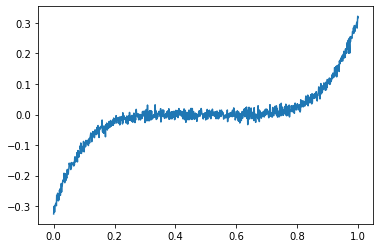

In [11]:
rng = np.random.default_rng(12345)
# generate the data here
size = 1000
x = np.linspace(0,1,size)
y = 10*(x-0.5)**5+np.random.normal(0,0.01,size=size)
plt.plot(x,y,'-')

Now, we would typically normalize our data. I chose a dataset that is within a sufficient range with a sufficient distribution of values so we can forgoe this step here.

We also need to create our train/test/validation datasets. `scikit-learn` (`import sklearn`) comes with nice functions (`sklearn.model_selection.train_test_split()`) for shuffling and splitting data, or you could do it by hand.

Additionally, let's turn our `numpy` arrays into `torch` tensors and create a `TensorDataset` and `DataLoader`. Example syntax for (approriately shaped) `numpy` arrays are in a comment below.

In [15]:
from sklearn.model_selection import train_test_split
# create tensor data here
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1)
train_x = torch.tensor(x_train)
train_y = torch.tensor(y_train)
train_data = TensorDataset(train_x,train_y) # create your datset
train_dataloader = DataLoader(train_data, batch_size=32) # create your dataloader
val_x = torch.tensor(x_val)
val_y = torch.tensor(y_val)
test_x = torch.tensor(x_test)
test_y = torch.tensor(y_test)


# Building our neural network

This model has one input and one output. Let's begin by builing a dense, fully connected, regression neural network with **one hidden layer that contains two nodes** (yah, not a very flexible network, but we want to practice tuning). We will begin with a Sigmoid activation function

To do this, we will inherit from the `torch.nn.Module` class. Look at the [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) documentation for guidance.

Often this is in a python module that may be imported into the notebook for interactive training, as we will do here. 

In [ ]:
class NN(nn.Module):
    '''
    A dense, fully connected neural network.
    '''
    def __init__(self):
        '''
        Constructor. Sets up the architecture.
        '''
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits 
        
    

We will create an *instance* of this class and print some information about the model.

As we did in the lecture, I like to count the number of trainable parameters for small netwroks to verify that I have built what I *think* I built :) Therefore, please draw out this small network and count your paramters before contiuing onto this next cell.

In [ ]:
model = NN() # create instance of NN

# print my architecture information
print(model)
print()
# counting my trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_params)
print()

# cycle through and print the params 
# this is more useful when there are more than one inputs or deeper networks
for parameter in model.parameters():
    print(parameter)


NameError: name 'NN' is not defined

# Training and Validation

We now need to define the training and validation functions. Again, this code could be offloaded into a module, but we will write it here.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    """
    Defines a training loop for one epoch (one pass through the training data)
    
    """
    
    model.train() # enter train mode

    for batch, (X, y) in enumerate(dataloader):
        
        # make a forward pass through the network
        pred = model(X) 

        # Compute prediction loss
        lossf = loss_fn(pred, y)

        # Backpropagation:
        optimizer.zero_grad() # we don't want to accumulate grads from previous batch
        lossf.backward() # back prop through networks
        optimizer.step() # update weights

        # Sometimes we want some feedback within an epoch
        # if batch % 10 == 0: 
        #     loss, current = lossf.item(), batch * len(X)
        #     #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return lossf.detach().numpy()

def val(dataloader, model, loss_fn):
  """
  Defines a validation loop for one pass through validation data.
  """

  # complete me. Use the train function for guidance
  # Hint: `with torch.no_grad()` disables gradient calculation...
  # we def don't want validation gradients leaking into our training!

   
  return val_loss


def test_preds(dataloader, model, loss_fn):
    """
    Code for making predictions from a trained model.

    returns: ARRAY of predictions
    """


    return x, yhat

def weight_reset(m):
  """
  initialize weights in network
  """
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
      m.reset_parameters()

The last thing we need to enable training is to define our loss function and our optimizer. We went over stochastic gradient descent (SGD) during the lecture, but there are many modifications of SGD. Adam is particularly popular for neural network training. 



In [ ]:
# define loss function
loss_fn = nn.#complete me
# define optimizer
optimizer = torch.optim.#complete me


MLP(
  (layers): Sequential(
    (0): Linear(in_features=5, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=1, bias=True)
  )
)
<bound method Module.parameters of MLP(
  (layers): Sequential(
    (0): Linear(in_features=5, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=1, bias=True)
  )
)>


# Train your network!

To start, train your regression network for 10 epochs with a batch size of 128, an Adam optimizer with a learning rate of 0.1, using mean squared error loss. **This is not ideal.** 



In [ ]:
restart = True


if restart:
  model.apply(weight_reset)
  loss = []
  val_loss = []
        


epochs = 100

for i in range(epochs):
   # train your model and keep track of your losses for your learning curve
   
    if i % 10 == 0:
        print(f"Epoch {t+1}\n-------------------------------")
        print("train loss:",lo)
        print("val loss:",vlo)
print("Done!")





Parameter containing:
tensor([[ 0.0212,  0.1496,  0.2247,  0.2913,  0.0744],
        [-0.2727,  0.1406,  0.1560,  0.3364,  0.4177],
        [-0.3213, -0.2507,  0.1224,  0.3617,  0.0757],
        [ 0.3521, -0.3132, -0.0040,  0.2971, -0.3568],
        [ 0.1461,  0.1133, -0.2353, -0.0120,  0.0987],
        [-0.4193,  0.4288,  0.2096,  0.2203,  0.3387]], requires_grad=True)
Parameter containing:
tensor([ 0.1111,  0.3128,  0.4089, -0.2211, -0.2969, -0.1644],
       requires_grad=True)
Parameter containing:
tensor([[ 0.2332,  0.3181, -0.0131,  0.2043, -0.3838, -0.1753]],
       requires_grad=True)
Parameter containing:
tensor([0.0927], requires_grad=True)
Epoch 1
-------------------------------
train loss: tensor(0.5858, grad_fn=<MseLossBackward0>)
val loss: 0.570015705241182
Epoch 51
-------------------------------
train loss: tensor(0.0643, grad_fn=<MseLossBackward0>)
val loss: 0.054213462546229746
Done!
Parameter containing:
tensor([[-0.0377,  0.1959,  0.1504,  0.2272, -0.0117],
        [

A learning curve will help us determine over and underfitting, which, in turn, helps us tune our model and training.

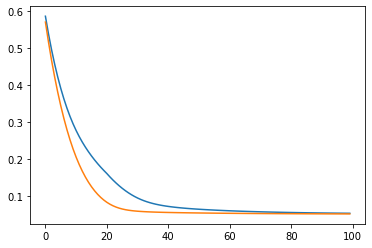

In [ ]:
# plot learning curve



Now, we want to make predictions from our trained model and plot the results.


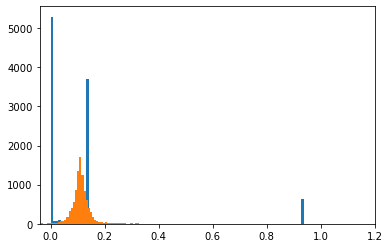

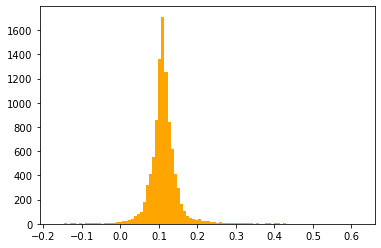

In [ ]:
# plot test set predictions and test set data on the same plot here



## Tuning
The model is learning, but we can do better. 

**At this point, you should play with the above code to change hyperparameters and note changes to your results.**

Alternatively, you can reference the step through tuning of a model below. The step-through tuning is from a more complicated learning problem (that I realized was kinda dumb so I changed it).

If you train the model effectively with time to spare, you can generate more challenging synthetic regression data. I multiplied the exisiting function by `np.sin(100*x)` as my next trial. Adding more inputs and or outputs is also a fun modification. 


## Walk-through tuning:
Perhaps we did not have enough model parameters to accurately represent the mapping. Remedy this by increasing the number of hidden nodes to 20.

In [ ]:
#Use the same code as in the previous cell
#simply change the number of neurons in the hidden layer

We see that we got little improvement here. Another hyperparameter to adjust is *batch size*, which is the number of training examples used to calculate the gradient on each step. While you may initially think that a higher batch size leads to faster or more accurate training, in practice this is not true. The "noise" that arises from using less training examples at each iteration can actually help find the global minimum of the loss function.
(See here for more info: https://arxiv.org/pdf/1609.04836.pdf)

Try decreasing the batch size to 16.

In [ ]:
#Complete me:


This is starting to do better but has significant room for improvement.

Another hyperparameter to tune is the *learning rate*. 

 - If the learning rate is too high, we are taking too large of a step in the gradient descent at each iteration and will miss narrow minima in the loss function. 
 - If the learning rate is too small, then we are not traveling far enough in each iteration and we will take far too long to reach a minimum. 

Perhaps the learning rate is too high and the network can't fine tune. Try decreasing the learning rate to 0.001.

In [ ]:

# Complete me:


This is not really that much better, but now there is evidence of *overtraining* or *overfitting* -- the training loss is so much lower than the validation loss. 

A common fix to this is adding *dropout layers*. Try adding a dropout layer with dropout rate of 0.5. https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

You can also try batch normalization: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html

In [ ]:
#Dropout layers are located under tf.keras.layers. 
#They take the dropout rate as their only argument.
#BatchNormalization layers are also under tf.keras.layers, and in the simplest use case, take no arguments

#Complete me:


This clearly stopped the overtraining problem, but it still isn't training well. Now, try training on the full dataset with a more reasonable validation split of 0.2. Use a single hidden layer with 20 neurons, a learning rate of 0.001, and a batch size of 256. Just run it for 10 epochs.

In [ ]:
#Complete me:


This clearly resulted in a significant improvement and shows how important having a large enough dataset is. Moving on to the choice in activation functions, ReLU is not the only available choice, although it is one of the most popular ones currently. Try training a network using a sigmoid or tanh activation function.

In [ ]:
#Simply change relu to sigmoid or tanh to change the activation function

#Complete me:


Next, try adding 2 new hidden layers to the network. Use the ReLU activation function.

In [ ]:
#Complete me:


Clearly, adding more layers helps improve the quality of the network. There is a limit to how effective this is though. Try having 5 hidden layers.

In [ ]:
#Complete me:


Now, see what happens when you increase the number of neurons per layer from 20 to 50 in the 3 hidden layer model. Consider how they perform compared to ReLU now. 

In [ ]:
#Complete me:


Try using the sigmoid and the tanh activation functions again and compare them to ReLU.

In [ ]:
#Complete me:


This difference in performance, especially with the sigmoid function, is known as the vanishing gradient problem. If the value for any one the neurons gets too far away from 0, the gradient for sigmoid and tanh gets really close to 0. This means that for deeper networks it is much more difficult to update the weights in the earlier layers as their gradient is so small. Now, remove the fifth column from the input data, the charge, and see what happens when training. Why do you think including charge has such a large impact?

In [ ]:
#Complete me:


Finally, there are other options for the loss function. Try experimenting with alternatives to mean squared error.

https://pytorch.org/docs/stable/nn.html#loss-functions

You can also try some other optimizers -- for example, sgd (with and without momentum), rmsprop, adagrad, adadelta, adamax, and nadam. https://pytorch.org/docs/stable/optim.html#algorithms


